### Data Exploration

In [1]:
# Import necessary libraries
import pandas as pd

In [2]:
# Load the dataset to inspect its structure
tweet_data = pd.read_csv('./data_file/tweet_sentiments.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset
tweet_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset consists of the following key columns:

* `tweet_text`: The actual text of the Tweet.
* `emotion_in_tweet_is_directed_at`: The product or brand mentioned in the Tweet (e.g., iPhone, iPad, Google).
* `is_there_an_emotion_directed_at_a_brand_or_product`: The sentiment or emotion expressed in the Tweet (e.g., Positive emotion, Negative emotion).

In [4]:
# Get a summary of the dataset, including data types and non-null counts
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataset information:

- The dataset contains **9,093 entries** and **3 columns**.
- All the columns are of the data type **object** (textual data).
- The dataset has some missing values in the `tweet_text` and `emotion_in_tweet_is_directed_at` columns.

In [5]:
# Display a summary of the missing values
tweet_data.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

The missing values in the dataset:

- `tweet_text`: 1 missing value. We will drop the row containing the missing text. 
- `emotion_in_tweet_is_directed_at`: 5802 missing values - could suggest that for many tweets, the emotion is not directed at a specific brand or product.  We will thus drop this column because it is not crucial for sentiment classification as our primary target is the sentiment. It is also not rational to fill in all the missing values with mean, median or mode for this column.
- `is_there_an_emotion_directed_at_a_brand_or_product`: 0 missing values.

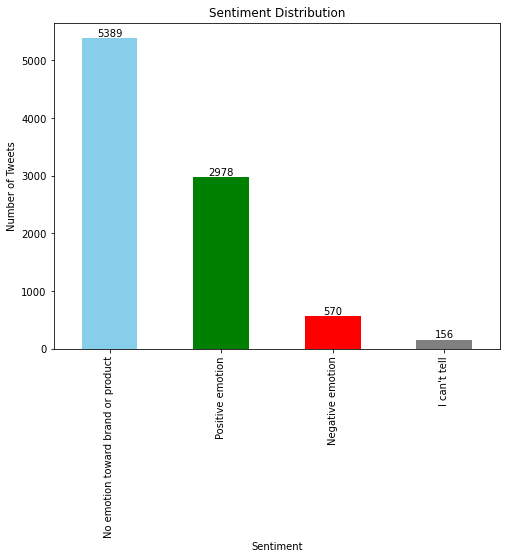

In [8]:
import matplotlib.pyplot as plt

# Check the distribution of the sentiment
sentiment_distribution = tweet_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
ax = sentiment_distribution.plot(kind='bar', color=['skyblue', 'green', 'red', 'gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

The sentiment distribution shows a significant imbalance that need to be addressed during pre-processing through appropriate methods. Majority of the tweets (5,389) have no emotion directed at a brand or product, while positive emotions (2,978) are significantly more represented than negative emotions (570). 156 instances are labeled as "I can't tell" which we could remove or filter out.

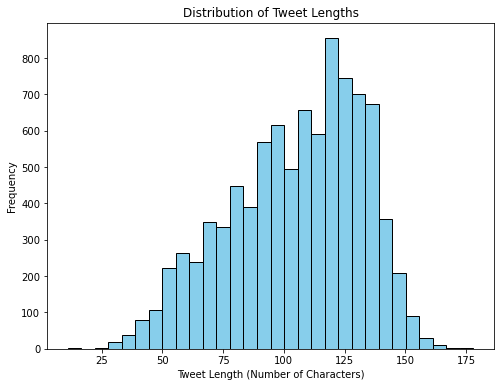

In [9]:
# Analyze the text length by calculating the number of characters in each tweet
tweet_lengths = tweet_data['tweet_text'].str.len()

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 6))
plt.hist(tweet_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Most tweets appear to fall within a moderate length range, with the majority clustered between shorter lengths (as expected with tweet constraints). Since the dataset is not too huge, we will not truncate the tweets during tokenization.

In [10]:

from collections import Counter
from nltk.tokenize import word_tokenize

# Clean the tweet_text by dropping rows with missing text values
tweet_data_cleaned = tweet_data.dropna(subset=['tweet_text'])

# Tokenize the cleaned tweets by sentiment
positive_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['tweet_text'].str.split()
negative_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['tweet_text'].str.split()
neutral_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']['tweet_text'].str.split()

# Flatten the tokenized tweets into a single list per sentiment
positive_words = [word.lower() for tweet in positive_tweets for word in tweet if word]
negative_words = [word.lower() for tweet in negative_tweets for word in tweet if word]
neutral_words = [word.lower() for tweet in neutral_tweets for word in tweet if word]

# Count the most common words in each sentiment
positive_common_words = Counter(positive_words).most_common(10)
negative_common_words = Counter(negative_words).most_common(10)
neutral_common_words = Counter(neutral_words).most_common(10)

positive_common_words, negative_common_words, neutral_common_words

([('#sxsw', 2506),
  ('@mention', 2062),
  ('the', 1578),
  ('{link}', 1202),
  ('to', 1146),
  ('at', 999),
  ('rt', 913),
  ('for', 904),
  ('ipad', 793),
  ('a', 777)],
 [('#sxsw', 512),
  ('the', 300),
  ('@mention', 292),
  ('to', 255),
  ('is', 159),
  ('a', 151),
  ('ipad', 140),
  ('at', 137),
  ('rt', 137),
  ('of', 131)],
 [('#sxsw', 4680),
  ('@mention', 4249),
  ('{link}', 2904),
  ('the', 2409),
  ('to', 2112),
  ('at', 1868),
  ('rt', 1814),
  ('for', 1474),
  ('a', 1281),
  ('google', 1187)])

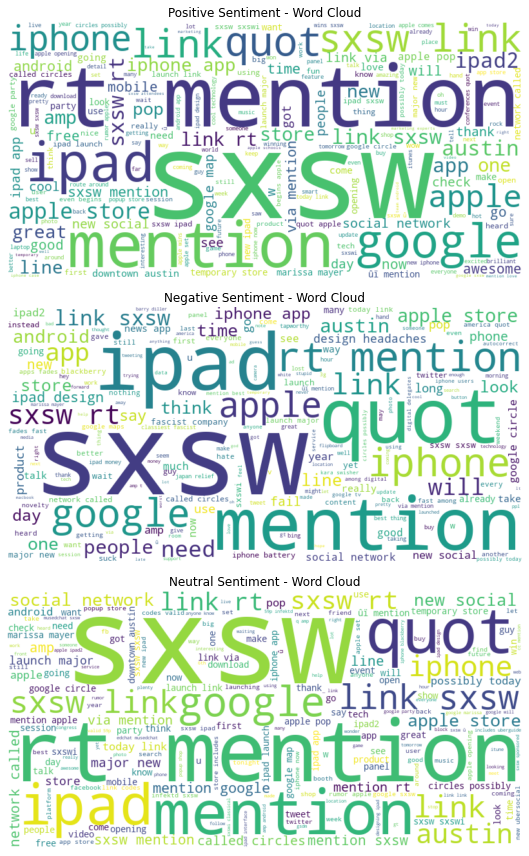

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each sentiment category
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_words))
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_words))

# Plot the word clouds for each sentiment
plt.figure(figsize=(16, 12))

# Positive sentiment word cloud
plt.subplot(3, 1, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment - Word Cloud')

# Negative sentiment word cloud
plt.subplot(3, 1, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment - Word Cloud')

# Neutral sentiment word cloud
plt.subplot(3, 1, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Sentiment - Word Cloud')

plt.tight_layout()
plt.show()

The word clouds reveal that event-related terms like "SXSW", "mention", and "link" dominate across all sentiment categories, indicating that the dataset contains many tweets focused on the SXSW event rather than expressing sentiment. Product-related terms like "iPhone", "iPad", and "Google" are also frequent, but sentiment-specific words are limited. This suggests that pre-processing adjustments, such as removing non-informative terms (e.g., mentions, links, hashtags) and refining the handling of product-specific words, could help improve sentiment analysis.